#### Get Data

In [1]:
!rm data.csv
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-08 14:26:48--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.06s   

2023-10-08 14:26:48 (23.2 MB/s) - ‘data.csv’ saved [1475504/1475504]



#### Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

#### Load data

In [3]:
df = pd.read_csv("data.csv")
print(f"Rows: {df.shape[0]:,}")
print(f"Cols: {df.shape[1]}")
df.head()

Rows: 11,914
Cols: 16


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


#### Data preparation

In [4]:
# Keep the specified columns
VARIABLES = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = df[VARIABLES]

In [5]:
# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [6]:
# Fill in the missing values of the selected features with 0
df.fillna(0, inplace=True)

In [7]:
#### Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`
df["above_average"] = (df["msrp"] > df["msrp"].mean()).astype(int)

In [8]:
### Split the dataset into 3 parts -> train, val, and test with 60%, 20%, 20% distribution.
X_train_full, X_test, y_train_full, y_test = train_test_split(df.drop(["msrp", "above_average"], axis=1), df["above_average"], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)

#### Question 1: ROC AUC feature importance

In [9]:
NUMERIC = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
CATEGORIC = ["make", "model", "transmission_type", "vehicle_style"]

In [10]:
auc_scores = {}

for var in NUMERIC:
    auc = roc_auc_score(y_train, X_train[var])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[var])

    auc_scores[var] = auc


In [11]:
pd.DataFrame.from_dict(auc_scores, orient="index", columns=["AUC Score"]).sort_values(by="AUC Score", ascending=False)

,AUC Score
engine_hp,0.916232
engine_cylinders,0.767441
year,0.684748
city_mpg,0.675462
highway_mpg,0.635193


In [12]:
max(auc_scores, key=auc_scores.get)

'engine_hp'

#### Question 2: Training the model

In [13]:
# Encode categorical columns
encoder = DictVectorizer(sparse=False)
encoder.fit(X_train[CATEGORIC].to_dict(orient="records"))
X_train_enc = pd.concat(
    [
        X_train[NUMERIC],
        pd.DataFrame(encoder.transform(X_train[CATEGORIC].to_dict(orient="records")),
                      columns=encoder.get_feature_names_out(),
                      index=X_train.index)
    ],
    axis=1
)
X_val_enc = pd.concat(
    [
        X_val[NUMERIC],
        pd.DataFrame(encoder.transform(X_val[CATEGORIC].to_dict(orient="records")),
                      columns=encoder.get_feature_names_out(),
                      index=X_val.index)
    ],
    axis=1
) 

In [14]:
# Train the model
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train_enc, y_train)
print(f"val AUC: {round(roc_auc_score(y_val, lr.predict_proba(X_val_enc)[:, 1]), 3)}")

val AUC: 0.978


#### Question 3: Precision and Recall

In [15]:
proba = lr.predict_proba(X_val_enc)[:, 1]

In [16]:
thresholds = np.arange(0, 1.0, 0.01)
thresholds_scores = {}

for thresh in thresholds:
    precision = precision_score(y_val, proba > thresh)
    recall = recall_score(y_val, proba > thresh)

    thresholds_scores[thresh] = {
        "precision": precision,
        "recall":recall,
        "abs_difference": abs(precision - recall)
    }
thresholds_scores_df = pd.DataFrame.from_dict(thresholds_scores, orient="index")

In [17]:
# Find the threshold where precision and recall intersect
intersection_threshold = thresholds_scores_df["abs_difference"].idxmin()
intersection_threshold

0.49

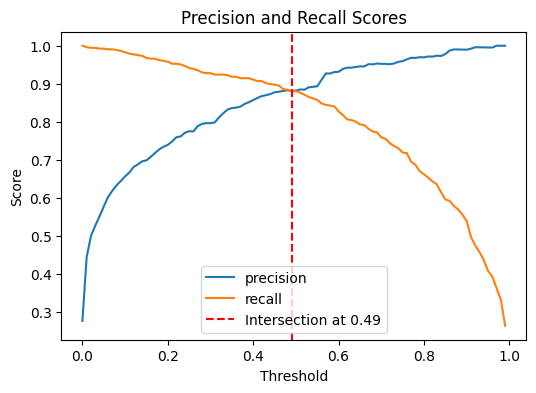

In [18]:
thresholds_scores_df.drop("abs_difference", axis=1).plot(figsize=(6, 4), ylabel="Score", xlabel="Threshold", title="Precision and Recall Scores")
plt.axvline(intersection_threshold, color='red', linestyle='--', label=f'Intersection at {intersection_threshold:.2f}')
plt.legend()
plt.show()

#### Question 4: F1 score

In [19]:
thresholds[np.argmax([f1_score(y_val, proba > thresh) for thresh in thresholds])]

0.45

In [20]:
for anw in [0.12, 0.32, 0.52, 0.72]:
    print(f"Threshold: {anw}, F1 Score: {f1_score(y_val, proba > anw):.3f}")

Threshold: 0.12, F1 Score: 0.803
Threshold: 0.32, F1 Score: 0.864
Threshold: 0.52, F1 Score: 0.878
Threshold: 0.72, F1 Score: 0.835


#### Question 5: 5-Fold CV

In [21]:
# Encode categorical columns
encoder = DictVectorizer(sparse=False)
encoder.fit(X_train_full[CATEGORIC].to_dict(orient="records"))
X_train_full_enc = pd.concat(
    [
        X_train_full[NUMERIC],
        pd.DataFrame(encoder.transform(X_train_full[CATEGORIC].to_dict(orient="records")),
                      columns=encoder.get_feature_names_out(),
                      index=X_train_full.index)
    ],
    axis=1
)

In [22]:
cross_val_score(
    estimator=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000),
    X=X_train_full_enc,
    y=y_train_full,
    cv=KFold(n_splits=5, shuffle=True, random_state=1),
    scoring="roc_auc",
    n_jobs=-1) \
.std().round(3)

0.001

#### Question 6: Hyperparemeter Tuning

In [23]:
c_values = [0.01, 0.1, 0.5, 10]

In [24]:
results = {}

for c in c_values:
    auc_scores = cross_val_score(
        estimator=LogisticRegression(solver='liblinear', C=c, max_iter=1000),
        X=X_train_full_enc,
        y=y_train_full,
        cv=KFold(n_splits=5, shuffle=True, random_state=1),
        scoring="roc_auc",
        n_jobs=-1)

    results[c] = {
        "mean": auc_scores.mean().round(3),
        "std": auc_scores.std().round(3)
    }

In [40]:
pd.DataFrame.from_dict(results, orient="index").sort_values(by="mean", ascending=False)

,mean,std
10.00,0.983,0.002
0.50,0.979,0.003
0.10,0.972,0.002
0.01,0.952,0.002
